In [15]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Mapping tools
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier

In [16]:
# Read files (when in same folder as this notebook)
levitus_file = "Levitus_climatology.nc"
levitus = xr.open_dataset(levitus_file, engine="scipy", decode_times=False)

ocean_atmosphere_heat_flux_file = "Ocean-atmosphere_heat-flux.nc"
oa_heat_flux = xr.open_dataset(ocean_atmosphere_heat_flux_file, engine="scipy", decode_times=False)

# Not yet used
isopycnal_file = "MIMOC_Z_GRID_v2.2_PT_S_month01.nc"
isopycnal = xr.open_dataset(isopycnal_file, decode_times=False)

In [17]:
# Define given values
specific_heat_capacity = 3.94e3
density = 1024

In [18]:
# Set the basic mapping parameters
suptitle_size = 20 # Size for the main title 
title_size = 16 # Size for fonts
mapsize = (16, 4) 
map_projection = Mollweide()

# Define a function that gives basic mapping parameters like land, coastline and gridlines
def basemap(ax):
    ax.add_feature(LAND)
    ax.add_feature(COASTLINE)
    ax.gridlines(draw_labels=["left", "bottom"], 
        y_inline=False, x_inline=False) # Labels for  the coordinates are not within the map, but outside
    return ax

In [19]:
# Integrate Temperature over the topmost 1000 meters
integrated_temperature = (
        levitus
        .sel(Z=slice(0,1000)) # Select only the values within the topmost 1000 meters
        .integrate(coord="Z") # Integrate over the depth
        .temp # Take the Value
    ).rename({"X": "lon", "Y": "lat"}).T # Rename the dimensions for easier understanding, then transpose the data 


In [20]:
# Calculate the Change in ocean heatcontent over JJA (August - June) and DJF (Feb - Dec) respectively
ocean_heatcontent_change_JJA = (
    density * specific_heat_capacity * 
    (
        integrated_temperature.sel(T=7.5) -
        integrated_temperature.sel(T=5.5)
    )
)
ocean_heatcontent_change_DJF = (
    density * specific_heat_capacity * 
    (
        integrated_temperature.sel(T=1.5) -
        integrated_temperature.sel(T=11.5)
    )
)

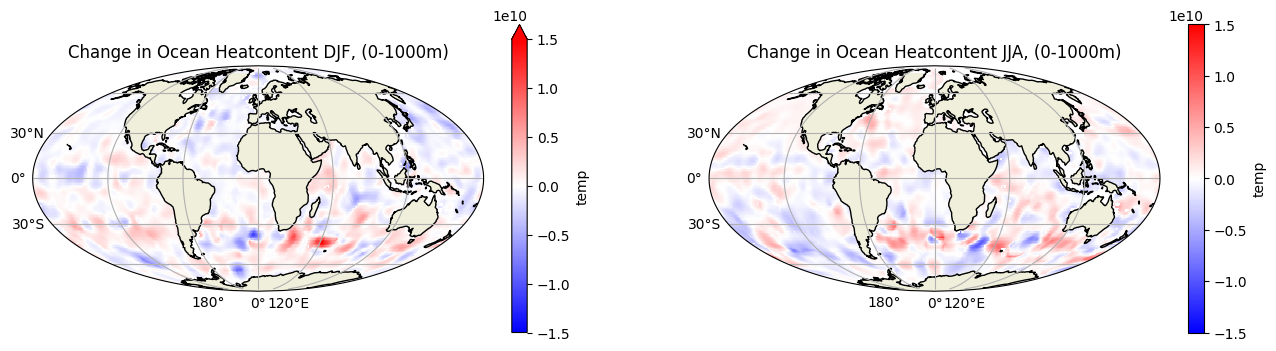

In [21]:
fig = plt.figure(figsize=mapsize)
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
ocean_heatcontent_change_DJF.plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Change in Ocean Heatcontent DJF, (0-1000m)")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
ocean_heatcontent_change_JJA.plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Change in Ocean Heatcontent JJA, (0-1000m)")
plt.show()

In [23]:
# change the coordinates from -180 - 180 to 0 -360
oa_heat_flux["lon"] = xr.where(
    oa_heat_flux["X"]<0, # take all the values, where X is less than zero
    oa_heat_flux["X"]+360, # if true, add 360
    oa_heat_flux["X"], # if false take them verbatim
)
oa_heat_flux = (
    oa_heat_flux
    .swap_dims({"X": "lon"}) # Make the new values to our dimension
    .sel(**{"lon":sorted(oa_heat_flux.lon)}) # make sure to sort them
    .drop("X") # drop the old Dimension
    .rename({"Y": "lat"}) # rename the Y to lat for easier understanding
)

/tmp/ipykernel_910/2748570796.py:11: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  .drop("X") # drop the old Dimension


In [24]:
# Get the total heat by multiplying eachs month value with the number of days in that month, 
# summing everything and then multiply by 24*60*60, as the unit is given per second
heatflux_DJF = (
    (oa_heat_flux.hfns.isel(T=11).T + oa_heat_flux.hfns.isel(T=0).T) * 31 + 
    oa_heat_flux.hfns.isel(T=1).T * 28
    ).T *24*60*60
heatflux_JJA = (
    (oa_heat_flux.hfns.isel(T=6).T + oa_heat_flux.hfns.isel(T=7).T)*31 +
    oa_heat_flux.hfns.isel(T=5).T*30
    ).T *24*60*60

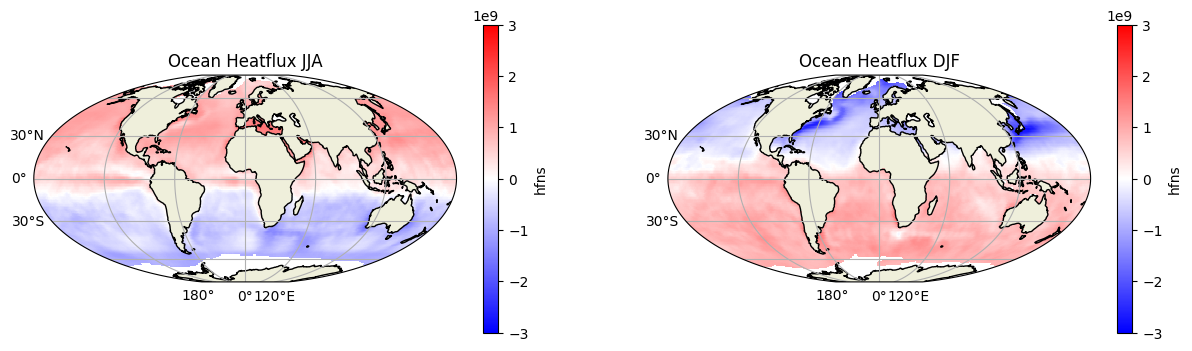

In [25]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
heatflux_JJA.plot(ax=ax, transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax.set_title("Ocean Heatflux JJA")
ax = fig.add_subplot(122, projection=Mollweide())
basemap(ax)
heatflux_DJF.plot(ax=ax, transform=PlateCarree(), vmin=-3e9, vmax=3e9, cmap="bwr")
ax.set_title("Ocean Heatflux DJF")
plt.show()

Text(0.5, 1.0, 'Heat Divergence JJA')

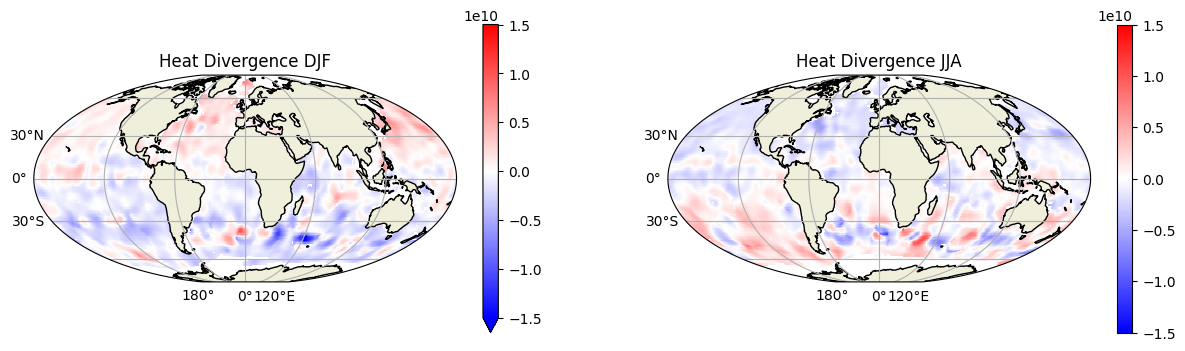

In [ ]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121, projection=Mollweide())
basemap(ax)
(-heatflux_DJF-ocean_heatcontent_change_DJF).plot(ax=ax, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax.set_title("Heat Divergence DJF")
ax2 = fig.add_subplot(122, projection=Mollweide())
basemap(ax2)
(-heatflux_JJA-ocean_heatcontent_change_JJA).plot(ax=ax2, transform=PlateCarree(), vmin=-1.5e10, vmax=1.5e10, cmap="bwr")
ax2.set_title("Heat Divergence JJA")
plt.show()

316.5 304.5
indicies: 30 255 281 609 633


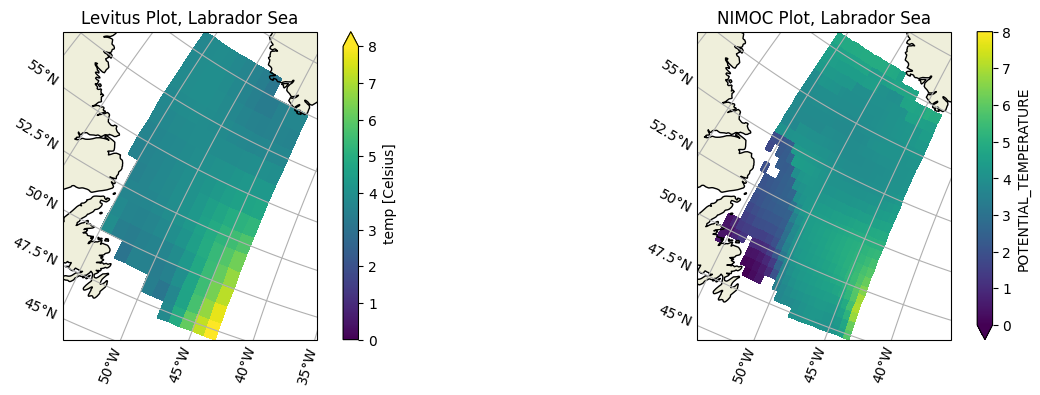

In [272]:
# Exercise 2
# depth 200m, 
# The International Hydrographic Organization defines the limits of the Labrador Sea as follows:[7]
#     On the North: the South limit of Davis Strait [The parallel of 60° North between Greenland and Labrador].
#     On the East: a line from Cape St. Francis 47°45′N 52°27′W (Newfoundland) to Cape Farewell (Greenland) 59.7792° N, 43.9117° W.
#     On the West: the East Coast of Labrador and Newfoundland and the Northeast limit of the Gulf of St. Lawrence 
#       – a line running from Cape Bauld (North point of Kirpon Island, 51°40′N 55°25′W) to the East extreme of Belle Isle 
#       and on to the Northeast Ledge (52°02′N 55°15′W). Thence a line joining this ledge with the East extreme of Cape St. Charles (52°13'N) in Labrador.
# Irminger sea: 62°N 35°W
# source: wikipedia

pressure = 200
latitude1 = 47.5
latitude2 = 60.5
longitude1 = 43.5
longitude2 = 55.5

def w_to_e(west):
    return 360-west

long1 = w_to_e(longitude1)
long2 = w_to_e(longitude2)
print(long1, long2)

labrador_levitus = levitus.sel(Z=pressure, T=0.5, Y=slice(latitude1, latitude2), X=slice(long2, long1)).temp.T

pres = np.where(isopycnal.PRESSURE.values == pressure)[0][0]
lat1 = np.where(isopycnal.LATITUDE.values == latitude1)[0][0]
lat2 = np.where(isopycnal.LATITUDE.values == latitude2)[0][0]
lon1 = np.where(isopycnal.LONGITUDE.values == long2)[0][0]
lon2 = np.where(isopycnal.LONGITUDE.values == long1)[0][0]
print("indicies:", pres, lat1, lat2, lon1, lon2)

labrador_isopycnal = isopycnal.set_coords(names=["LATITUDE", "LONGITUDE", "PRESSURE"])                              
labrador_isopycnal = labrador_isopycnal.isel(PRES=pres, LAT=slice(lat1, lat2+1), LONG=slice(lon1, lon2+1))

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(121, projection=ccrs.Stereographic())
basemap(ax)
labrador_levitus.plot(ax=ax, vmin=0, vmax=8, transform=PlateCarree())
ax.set_title("Levitus Plot, Labrador Sea")
ax2 = fig.add_subplot(122, projection=ccrs.Stereographic())
basemap(ax2)
labrador_isopycnal.POTENTIAL_TEMPERATURE.plot(ax=ax2, x="LONGITUDE", y="LATITUDE", vmin=0, vmax=8, transform=PlateCarree())
ax2.set_title("NIMOC Plot, Labrador Sea")
plt.show()